### **Causal inference** is the process of determining whether one variable (often called the "treatment" or "cause") **directly affects another variable** (the "outcome" or "effect"). This is different from **correlation**, which simply measures whether two variables **move together**, without implying that one causes the other.

####Example: The Effect of Studying on Exam Scores
####Imagine you're a student trying to figure out if studying more hours leads to better exam scores. Here's how you might approach this question using causal inference:

Treatment (Cause): Number of hours spent studying.
Outcome (Effect): Exam score.
Confounders: Other variables that might affect both studying and exam scores (e.g., previous knowledge, hours of sleep, access to study materials).





#### There are various methods for causal inference, including **randomized controlled trials (RCTs)**, **instrumental variables (IV), propensity score matching**, and more recently, methods using g**raphical models and machine learning.**

### I'll demonstrate a simple example of causal inference using the **DoWhy** library, which is designed for causal analysis. DoWhy provides a straightforward way to specify causal models and perform causal inference.


### **Propensity Score:** The probability of a unit (e.g., a customer) receiving the treatment given their observed characteristics.

## Problem: **Estimating the Effect of a** Loyalty Program **on** Insurance Claims
### Suppose an insurance company wants to estimate the effect of enrolling customers in a loyalty program on the number of insurance claims they file. Since customers are not randomly assigned to the loyalty program, there may be **confounding variables** that influence both the enrollment and the outcome (e.g., age, income, past claims history).

Steps for Propensity Score Application

**1. Data Preparation:** Create a dataset with treatment, outcome, and covariates.

**2. Propensity Score Estimation:** Estimate the probability of treatment assignment based on observed covariates.

**3. Matching/Weighting/Stratification:** Use propensity scores to balance the treatment and control groups.

**4. Outcome Analysis:** Compare the outcomes between the balanced groups to estimate the treatment effect.



In [1]:
import numpy as np
import pandas as pd

# Seed for reproducibility
np.random.seed(42)

# Generate synthetic data
num_samples = 1000
data = {
    'age': np.random.randint(18, 70, size=num_samples),
    'income': np.random.normal(50000, 10000, size=num_samples),
    'past_claims': np.random.randint(0, 5, size=num_samples),
    'loyalty_program': np.random.binomial(1, 0.3, size=num_samples),  # 30% in loyalty program
}

df = pd.DataFrame(data)

# Introduce a causal relationship
df['num_claims'] = df['loyalty_program'] * -0.5 + df['past_claims'] * 0.3 + np.random.normal(0, 1, num_samples)
df['num_claims'] = df['num_claims'].apply(lambda x: max(x, 0))  # Ensure non-negative claims

# Display the first few rows of the dataset
print(df.head())


   age        income  past_claims  loyalty_program  num_claims
0   56  33935.536797            4                0    1.705404
1   69  52034.636359            1                1    0.000000
2   46  42436.492547            3                1    1.095021
3   32  35777.462904            4                0    0.000000
4   60  43534.271158            3                1    0.000000


### **Matching:** Treated units (enrolled in the loyalty program) are matched with control units (not enrolled) based on their propensity scores using nearest neighbor matching.

### Matching is a method to pair each treated unit with one or more control units that have similar propensity scores. This aims to balance the distribution of observed covariates between the treated and control groups, reducing the bias due to confounding variables.

### Nearest Neighbor Matching: Each treated unit is matched with the closest control unit(s) based on the propensity score. In this example, we use 1-to-1 nearest neighbor matching.

### In observational studies, like our insurance, the treatment (enrollment in a loyalty program) is not randomly assigned. This can lead to biased estimates of the treatment effect because the treated and untreated groups might differ in ways that also affect the outcome (number of claims). Matching helps to make these groups comparable.

### How do we do Matching?
### We use propensity scores, which are the **estimated probabilities that a customer will be in the loyalty program based on their characteristics** (age, income, past claims). We then match each treated customer with one or more control customers who have similar propensity scores.

### Steps in Matching :

**Estimate Propensity Scores:** Use logistic regression to calculate the probability of each customer being in the loyalty program based on their age, income, and past claims.

**Find Matches:** For each customer in the loyalty program (treated), find a customer not in the program (control) with a similar propensity score. This is like finding "twins" based on the probability of receiving the treatment.

**Create Matched Dataset:** Combine the treated customers and their matched controls into a new dataset that will be used for analysis.



In [2]:

from sklearn.linear_model import LogisticRegression

# Define features and treatment
X = df[['age', 'income', 'past_claims']]
y = df['loyalty_program']

# Fit logistic regression to estimate propensity scores
logistic = LogisticRegression()
logistic.fit(X, y)

# Predict propensity scores
df['propensity_score'] = logistic.predict_proba(X)[:, 1]

# Display the first few rows with propensity scores
print(df.head())

   age        income  past_claims  loyalty_program  num_claims  \
0   56  33935.536797            4                0    1.705404   
1   69  52034.636359            1                1    0.000000   
2   46  42436.492547            3                1    1.095021   
3   32  35777.462904            4                0    0.000000   
4   60  43534.271158            3                1    0.000000   

   propensity_score  
0          0.367947  
1          0.303733  
2          0.337029  
3          0.361145  
4          0.333129  


In [3]:
from sklearn.neighbors import NearestNeighbors

# Separate treated and control groups
treated = df[df['loyalty_program'] == 1]
control = df[df['loyalty_program'] == 0]

# Fit nearest neighbors model
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find nearest neighbors in the control group for each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control units
matched_controls = control.iloc[indices.flatten()]

# Combine treated and matched control units
matched_df = pd.concat([treated, matched_controls])

# Display the first few rows of the matched dataset
print(matched_df.head())


   age        income  past_claims  loyalty_program  num_claims  \
1   69  52034.636359            1                1    0.000000   
2   46  42436.492547            3                1    1.095021   
4   60  43534.271158            3                1    0.000000   
7   56  58816.397569            2                1    0.633401   
8   36  49920.273587            1                1    0.000000   

   propensity_score  
1          0.303733  
2          0.337029  
4          0.333129  
7          0.281364  
8          0.310908  


### Average treatment effect (ATE) measures the average effect of a treatment on an outcome variable. There are different methods to estimate the ATE but it is often estimated using sample means as :

In [4]:
# Calculate average treatment effect
ate = matched_df[matched_df['loyalty_program'] == 1]['num_claims'].mean() - \
      matched_df[matched_df['loyalty_program'] == 0]['num_claims'].mean()

print(f'Average Treatment Effect (ATE): {ate}')


Average Treatment Effect (ATE): -0.24684751491563378


### To solve the insurance loyalty claim problem we can also the **DoWhy** library, with thefollowing steps:


Causal Model Specification: Define the causal model including treatment, outcome, and confounders.

Identify the Causal Effect: Use DoWhy to identify the causal effect.

Estimate the Causal Effect: Estimate the causal effect using an appropriate method.

Refute the Estimate: Perform robustness checks to ensure the validity of the causal effect

In [5]:
#! pip install dowhy

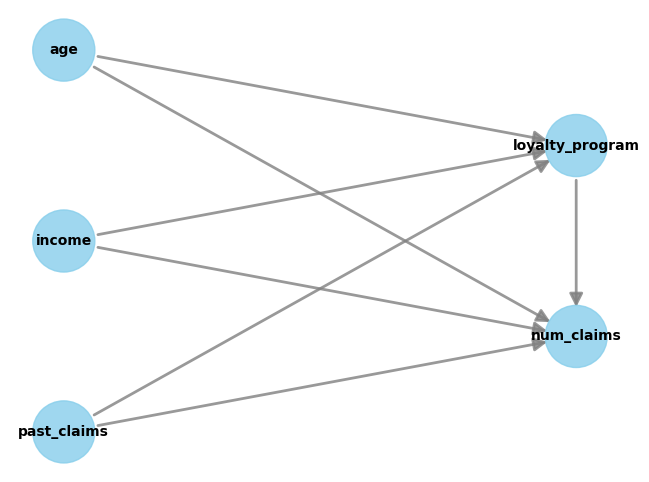

In [6]:

import dowhy
from dowhy import CausalModel

# Define the causal model
model = CausalModel(
    data=df,
    treatment='loyalty_program',
    outcome='num_claims',
    common_causes=['age', 'income', 'past_claims']
)

# View the model
model.view_model()


Methodology: The estimand is identified using backdoor adjustment (in the first estimand) and instrumental variables (in the second estimand), as indicated by the **backdoor** and **iv** names.


Estimand Type: The identified estimand is for the Average Treatment Effect (ATE), which measures the average effect of the treatment on the outcome.

Estimand Expression: This describes the mathematical expression used to estimate the causal effect, typically involving conditional expectations or derivatives.

Estimand Assumptions: These assumptions specify the conditions under which the identified estimand is valid. For example, unconfoundedness assumes that there are no unobserved confounders affecting both the treatment assignment and the outcome.



In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                               
──────────────────(E[num_claims|income,age,past_claims])
d[loyalty_program]                                      
Estimand assumption 1, Unconfoundedness: If U→{loyalty_program} and U→num_claims then P(num_claims|loyalty_program,income,age,past_claims,U) = P(num_claims|loyalty_program,income,age,past_claims)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Backdoor Estimand: It shows how the loyalty program might change the number of claims people make, once we think about differences in past claims, income, and age. We have to think about what else could affect both the loyalty program and the number of claims.

IV and Frontdoor Estimands: These couldn't be used here because we didn't have good examples of other things that could help us understand how the loyalty program affects the number of claims people make.



In [8]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                               
──────────────────(E[num_claims|income,age,past_claims])
d[loyalty_program]                                      
Estimand assumption 1, Unconfoundedness: If U→{loyalty_program} and U→num_claims then P(num_claims|loyalty_program,income,age,past_claims,U) = P(num_claims|loyalty_program,income,age,past_claims)

## Realized estimand
b: num_claims~loyalty_program+income+age+past_claims
Target units: ate

## Estimate
Mean value: -0.2908133591203509



The estimated ATE of joining the loyalty program on the number of claims is approximately -0.291. This suggests that, on average, joining the loyalty program is associated with a decrease in the number of claims. However, be cautious in interpreting the sign of the estimate (- or +) as it depends on how the outcome variable is coded and the direction of the effect being studied.

## **Refutation**: We perform robustness checks to ensure the causal effect is not due to random chance or unobserved confounders.

In [9]:
# Refute the causal estimate
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)

print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:-0.2908133591203509
New effect:0.003572994964809897
p value:0.96



### The original estimated effect was -0.2908133591203415, suggesting a negative impact of the treatment.

### After applying the placebo refutation, the new estimated effect is very close to zero (0.003572994964809586), which suggests that the observed effect may be due to a placebo effect or random chance.

The high p-value of 0.96 further supports that the difference between the original and refuted effects is not statistically significant.

## Conclusion:

This refutation suggests that the effect of the treatment is not robust against a placebo treatment. The observed effect is likely to be due to a placebo effect or random chance rather than a true causal effect of the treatment.